# MusicBrainz place geocoder

This notebook loads a set of artists from musicbrainz, gets each's place name (ie, either where they're from or where they're most associated with - as determined in other notebook), and geocodes that place name to lat long. Then it maps the artists.

Nominatim API documentation: https://wiki.openstreetmap.org/wiki/Nominatim

Sample Nominatim query: https://nominatim.openstreetmap.org/search?format=json&q=brixton,london,england

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time, requests
from mpl_toolkits.basemap import Basemap
from geopy.distance import great_circle

%matplotlib inline
pause = 0.75

## Define geocoding functions

Nominatim and Google APIs

In [3]:
def geocode_nominatim(address):
    time.sleep(pause)
    url = u'https://nominatim.openstreetmap.org/search?format=json&q={}'
    request = url.format(address)
    response = requests.get(request)
    data = response.json()
    if len(data) > 0:
        return '{},{}'.format(data[0]['lat'], data[0]['lon'])

In [2]:
def geocode_google(address):
    time.sleep(pause)
    url = u'http://maps.googleapis.com/maps/api/geocode/json?sensor=false&address={}'
    request = url.format(address)
    response = requests.get(request)
    data = response.json()
    if len(data['results']) > 0:
        latitude = data['results'][0]['geometry']['location']['lat']
        longitude = data['results'][0]['geometry']['location']['lng']
        return '{},{}'.format(latitude, longitude)

## Test it

In [4]:
address = u"Brixton, London, England, United Kingdom"
latlng_google = geocode_google(address)
latlng_nominatim = geocode_nominatim(address)

In [5]:
print '{} google'.format(latlng_google)
print '{} nominatim'.format(latlng_nominatim)
print '{} miles apart'.format(round(great_circle(latlng_google, latlng_nominatim).miles, 2))

51.4612794,-0.1156148 google
51.4568044,-0.1167958 nominatim
0.31 miles apart


## Run it

In [6]:
artists = pd.read_csv('data/mb - Copy.csv', encoding='utf-8')
print '{:,} total artists'.format(len(artists))

# drop nans and get the unique set of places
addresses = pd.Series(artists['place_full'].dropna().sort_values().unique())
print '{:,} unique places'.format(len(addresses))

1,180 total artists
408 unique places


In [7]:
def get_country_if_more_detail(address):
    tokens = address.split(',')
    if len(tokens) > 1:
        return tokens[-1].strip()

# if a place contains only country name, check if that country name exists with more detail elsewhere in the list of places
# countries_with_more_detail is a list of all the countries that appear at end of comma-separated address strings
countries_with_more_detail = pd.Series(addresses.map(get_country_if_more_detail).dropna().sort_values().unique())
print '{:,} countries with more detail'.format(len(countries_with_more_detail))

# if so, discard the instance that is country name only - this country is represented elsewhere in list with finer grain info
# ie, keep 'estonia' if there is no 'talinn, estonia' elsewhere in list, 
# but discard 'russia' if 'moscow, russia' exists elsewhere in the list
addresses_to_geocode = addresses[~addresses.isin(countries_with_more_detail)]
print '{:,} unique addresses to geocode'.format(len(addresses_to_geocode))

38 countries with more detail
385 unique addresses to geocode


In [8]:
# geocode (with nominatim) each retained address (ie, full place name string)
start_time = time.time()

latlng_dict = {}
for address, n in zip(addresses_to_geocode, range(len(addresses_to_geocode))):
    if n % 10 == 0: print n,
    latlng_dict[address] = geocode_nominatim(address)

finish_time = time.time()

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380


In [9]:
print 'nominatim geocoded {:,} addresses in {:,} seconds'.format(len(addresses_to_geocode), int(finish_time-start_time))
print 'received {:,} non-null lat-longs'.format(len([key for key in latlng_dict if latlng_dict[key] is not None]))

nominatim geocoded 385 addresses in 591 seconds
received 374 non-null lat-longs


In [10]:
# which addresses failed to geocode successfully?
addresses_to_geocode = [ key for key in latlng_dict if latlng_dict[key] is None ]
addresses_to_geocode

[u'[Worldwide]',
 u'Liverpool, Merseyside, England, United Kingdom',
 u'Red Oak, Ellis County, Texas, United States',
 u'Kew Gardens Hills, Queens, New York, New York, United States',
 u'West Babylon, Babylon, Suffolk County, New York, United States',
 u'Columbia, Lexington County, South Carolina, United States',
 u'East Kilbride, South Lanarkshire, Scotland, United Kingdom',
 u'Washington, D.C., United States',
 u'City of Blue Mountains, New South Wales, Australia',
 u'Dunedin, Otago, South Island, New Zealand',
 u'Nelson City, South Island, New Zealand']

In [11]:
# now geocode (with google) each address that failed with nominatim
if len(addresses_to_geocode) < 2500:
    start_time = time.time()
    for address, n in zip(addresses_to_geocode, range(len(addresses_to_geocode))):
        if n % 10 == 0: print n,
        latlng_dict[address] = geocode_google(address)
    finish_time = time.time()

0 10


In [12]:
print 'google geocoded {:,} addresses in {:,} seconds'.format(len(addresses_to_geocode), int(finish_time-start_time))
print 'received {:,} non-null lat-longs'.format(len([key for key in latlng_dict if latlng_dict[key] is not None]))

google geocoded 11 addresses in 9 seconds
received 385 non-null lat-longs


In [13]:
# for each artist, if their place appears in the geocoded dict, pull the latlng value from dict into new df column
def get_latlng_by_address(address):
    try:
        return latlng_dict[address]
    except:
        return None

artists['place_latlng'] = artists['place_full'].map(get_latlng_by_address)
artists[['name', 'place_full', 'place_latlng']].sort_values(by='place_full').head()

,name,place_full,place_latlng
55,Chris Lake,"Aberdeen, Scotland, United Kingdom","57.1452452,-2.0913744"
1158,Radiohead,"Abingdon-on-Thames, Oxfordshire, England, Unit...","51.6714842,-1.2779714"
1074,Chinese Man,"Aix-en-Provence, Bouches-du-Rhône, Provence-Al...","43.5298424,5.4474738"
1164,Rancid,"Albany, Alameda County, California, United States","37.88687,-122.2977474"
1093,The Shins,"Albuquerque, Bernalillo County, New Mexico, Un...","35.0841034,-106.650985"


## Map it

In [14]:
# get discrete vectors of lats and lons, for easy x-y scatter-plotting
lats = artists['place_latlng'].dropna().map(lambda x: float(x.split(',')[0]))
lons = artists['place_latlng'].dropna().map(lambda x: float(x.split(',')[1]))

In [15]:
# define map colors
land_color = '#f5f5f3'
water_color = '#cdd2d4'
coastline_color = '#f5f5f3'
border_color = '#bbbbbb'
meridian_color = '#f5f5f3'
marker_fill_color = 'r'
marker_edge_color = 'None'

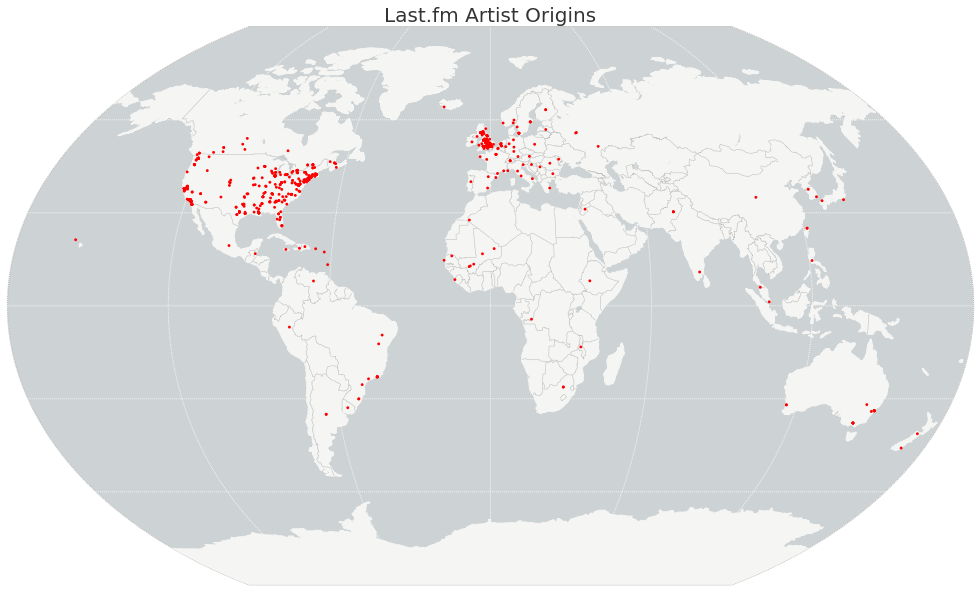

In [16]:
# create the plot
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, axisbg='#ffffff', frame_on=False)
ax.set_title('Last.fm Artist Origins', fontsize=20, color='#333333')

# draw the basemap and its features
m = Basemap(projection='kav7', lon_0=0, resolution='l', area_thresh=10000)
m.drawmapboundary(color=border_color, fill_color=water_color)
m.drawcoastlines(color=coastline_color)
m.drawcountries(color=border_color)
m.fillcontinents(color=land_color, lake_color=water_color)
m.drawparallels(np.arange(-90., 120., 30.), color=meridian_color)
m.drawmeridians(np.arange(0., 420., 60.), color=meridian_color)

# project our points from each dataset then concatenate and scatter plot them
x, y = m(lons.values, lats.values)
m.scatter(x, y, s=8, color=marker_fill_color, edgecolor=marker_edge_color, alpha=1, zorder=3)

# show the map
plt.savefig('images/lastfm_artists_origins_map.png', dpi=96, bbox_inches='tight', pad_inches=0.2)
plt.show()